In [1]:
'''
Programmer: Mike Kovacevich
Last edited: 1/13/20
E-mail: mgk56@drexel.edu

Comparing n_inj vs p-value for different time windows 
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy
import random

cy.plotting.mrichman_mpl()

timer = cy.timing.Timer()
time = timer.time

#Building/loading MESC data from analysis directory

ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.get_analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

/home/mkovacevich/py3venv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_MC.npy ...


/home/mkovacevich/py3venv/lib/python3.7/site-packages/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


Reading /data/ana/analyses/mese_cascades/version-001-p02/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/v

In [2]:
'Defining Functions'

##### Defining functions to compute flux ######    
def ndarray_to_TSD(trials):
    return cy.dists.TSD(cy.utils.Arrays(trials))

def tsd_merge(x):
    ts_values = np.concatenate([xx[0] for xx in x])
    n_zero = sum(xx[1] for xx in x)
    return cy.dists.TSD(ts_values, n_zero=n_zero)

def find_n_sig(beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'n_sig')
    #b = cy.bk.get_best(bg) #, 'gamma', gamma, 'dt', dt)
    b = bg
    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # include background trials in calculation
    trials = {0: tr.get_many_fits(10000)}
    trials.update(sig_trials)
    # get number of signal events
    # (arguments prevent additional trials from being run)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=1e5)

In [4]:
'Loading bg trials'

bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/0.01/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)

100 files loaded.                                                                 


100000.0
500 files loaded.                                                                     
float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 2.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 3.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 4.000 using 10.0 cores:
       1000/1000 trials complete.   

0:03:35.902657 elapsed.


"\n    fig, ax = plt.subplots()\n    for (n_sig, t) in zip(n_sigs, trials):\n        color = plt.get_cmap('plasma')(n_sig/2)\n        hl.plot1d(ax, hl.hist(t.nsigma, bins=20, range=(0,10)).normalize(),\n              color=color, label=r'$n_\text{{inj}}={}$'.format(n_sig))\n    ax.semilogy()\n    ax.legend(loc='upper left', bbox_to_anchor=[1,1], frameon=False)\n    ax.set(xlabel=r'number of $\\sigma$', ylabel='PDF')\n    ax.set_title('Injected events (gamma = '+str(gamma)+ ' and dt = '+str(dt)+' s)')\n    ax.grid()\n    fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Ninj_gamma_'+str(gamma)+'_dt_'+str(dt)+'.png',bbox_inches='tight')\n"

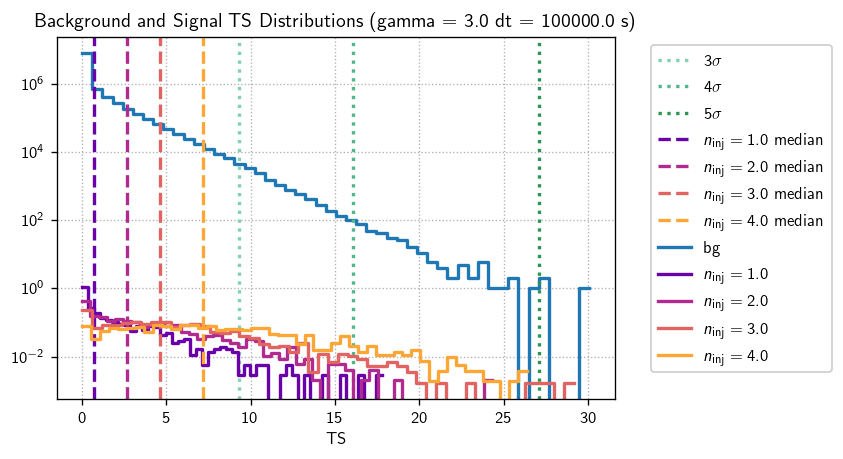

In [7]:
time_dt = [10000.0, 100000.0] #0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
gamma = 3.0
for i in time_dt:
    print(i)
    dt = i
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/{}/'.format(dt),
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    
    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10.0

    FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

    FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

    FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

    #using a random seed enables the use of different MC when scrambling
    rand_seed = random.randint(0, 1e5)

    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)

    if dt <= 10.0:
        n_sigs = np.r_[1.0:2.1:1.0]

    elif dt > 10.0:
        n_sigs = np.r_[1.0:4.1:1.0]

    print(n_sigs.dtype)
    with time('ps fit bias trials'):
        trials = [tr.get_many_fits(1000, n_sig=n_sig, logging=True, seed=random.randint(0, 1e5), poisson = False) for n_sig in n_sigs]

    for t in trials:
        t['mlog10p'] = bg.sf(t.ts)
        t['nsigma'] = bg.sf_nsigma(t.ts)
            #x = bg.trials.ts > t.ts / len(bg)

    sigma = [3,4,5]

    fig, ax = plt.subplots()
    h = bg.get_hist(bins = 50)
    hl.plot1d(ax, h, color='C0',label='bg')
    for i in sigma:
        color = plt.get_cmap('BuGn')(i/7)
        ax.axvline(bg.isf_nsigma(i),color=color, label = str(i)+r'$\sigma$',ls=':')

    for (n_sig, t) in zip(n_sigs, trials):
            color = plt.get_cmap('plasma')(n_sig/5)
            hl.plot1d(ax, hl.hist(t.ts, bins=50).normalize(),
                  color=color, label=r'$n_\text{{inj}}={}$'.format(n_sig))
            ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--')
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('TS')
    ax.set_title('Background and Signal TS Distributions (gamma = {} dt = {} s)'.format(gamma, dt))
    ax.semilogy()
    ax.grid()
    fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Normalized_grid_Bg_Sig_TSD_gamma_{}_dt_{}.png'.format(gamma, dt),bbox_inches='tight')

'''
    fig, ax = plt.subplots()
    for (n_sig, t) in zip(n_sigs, trials):
        color = plt.get_cmap('plasma')(n_sig/2)
        hl.plot1d(ax, hl.hist(t.nsigma, bins=20, range=(0,10)).normalize(),
              color=color, label=r'$n_\text{{inj}}={}$'.format(n_sig))
    ax.semilogy()
    ax.legend(loc='upper left', bbox_to_anchor=[1,1], frameon=False)
    ax.set(xlabel=r'number of $\sigma$', ylabel='PDF')
    ax.set_title('Injected events (gamma = '+str(gamma)+ ' and dt = '+str(dt)+' s)')
    ax.grid()
    fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Ninj_gamma_'+str(gamma)+'_dt_'+str(dt)+'.png',bbox_inches='tight')
'''

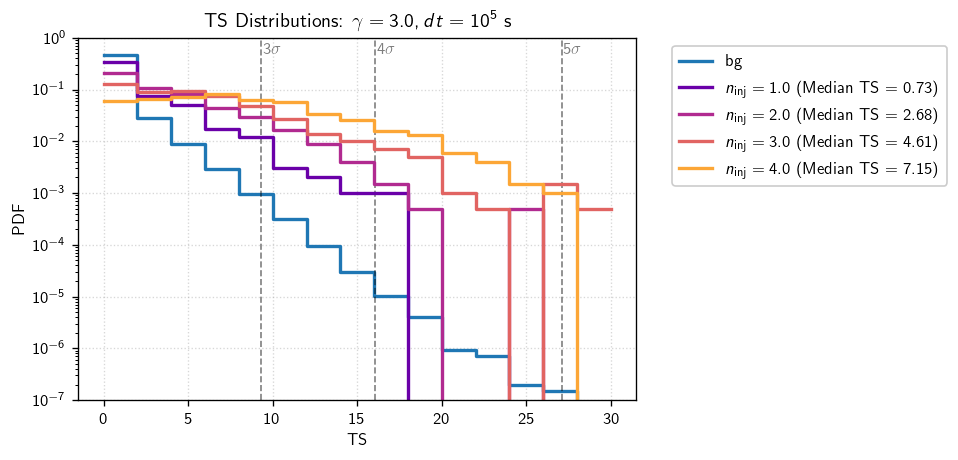

In [62]:
###Improving the plots (stylisitically) from above
sigma = [3,4,5]
pow = np.log10(dt)
title = fr'TS Distributions: $\gamma={gamma:.1f}, dt=10^{{{pow:.0f}}}$ s'

fig, ax = plt.subplots()
bins=np.r_[:31:2]
h = bg.get_hist(bins = bins)
hl.plot1d(ax, h.normalize(), color='C0',label='bg')
for i in sigma:
    #color = plt.get_cmap('BuGn')(i/7)
    ax.axvline(bg.isf_nsigma(i),color='k', ls='--', lw = 1.0, alpha = .5) #, label = str(i)+r'$\sigma$', ls=':', lw = 1.0, alpha = .5)
    ax.text(bg.isf_nsigma(i)+.1, .8, r'{}$\sigma$'.format(i), ha='left', va='top', alpha=.5)

for (n_sig, t) in zip(n_sigs, trials):
    color = plt.get_cmap('plasma')(n_sig/5)
    hl.plot1d(ax, hl.hist(t.ts, bins=bins).normalize(),
                  color=color, label=fr'$n_\text{{inj}}={n_sig}$ (Median TS = {np.median(t.ts):.2f})')  #.format(n_sig, np.median(t.ts)))
    #ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--',alpha = .6)

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel('TS')
ax.set_ylabel('PDF')
ax.set(ylim=(1e-7,1))
#ax.set_title('Background and Signal TS Distributions (gamma = {}, dt = {} s)'.format(gamma, dt))
ax.set_title(title)
ax.semilogy()
ax.grid(alpha = .5)
fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Test_Bg_Sig_TSD_gamma_{}_dt_{}.png'.format(gamma, dt),bbox_inches='tight')

In [4]:
### Plotting all plots in 1 panel ###
bg_trials = {}

time_dt = np.logspace(-2, 5, 8)

for dt in time_dt:
    bg_trials[dt] = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/{}/'.format(dt),
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)

In [6]:
print(bg_trials[0.01])

TSD(1000000000 trials, eta=0.000, median=0.000)


float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 2.000 using 10.0 cores:
       1000/1000 trials complete.   

0:00:46.816507 elapsed.
float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 2.000 using 10.0 cores:
       1000/1000 trials complete.   

0:00:47.818053 elapsed.
float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 2.000 using 10.0 cores:
       1000/1000 trials complete.   

0:00:47.779152 elapsed.
float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials complete.   
Performing 1000 trials with n_sig = 2.000 using 10.0 cores:
       1000/1000 trials complete.   

0:00:48.830089 elapsed.
float64
Performing 1000 trials with n_sig = 1.000 using 10.0 cores:
       1000/1000 trials 

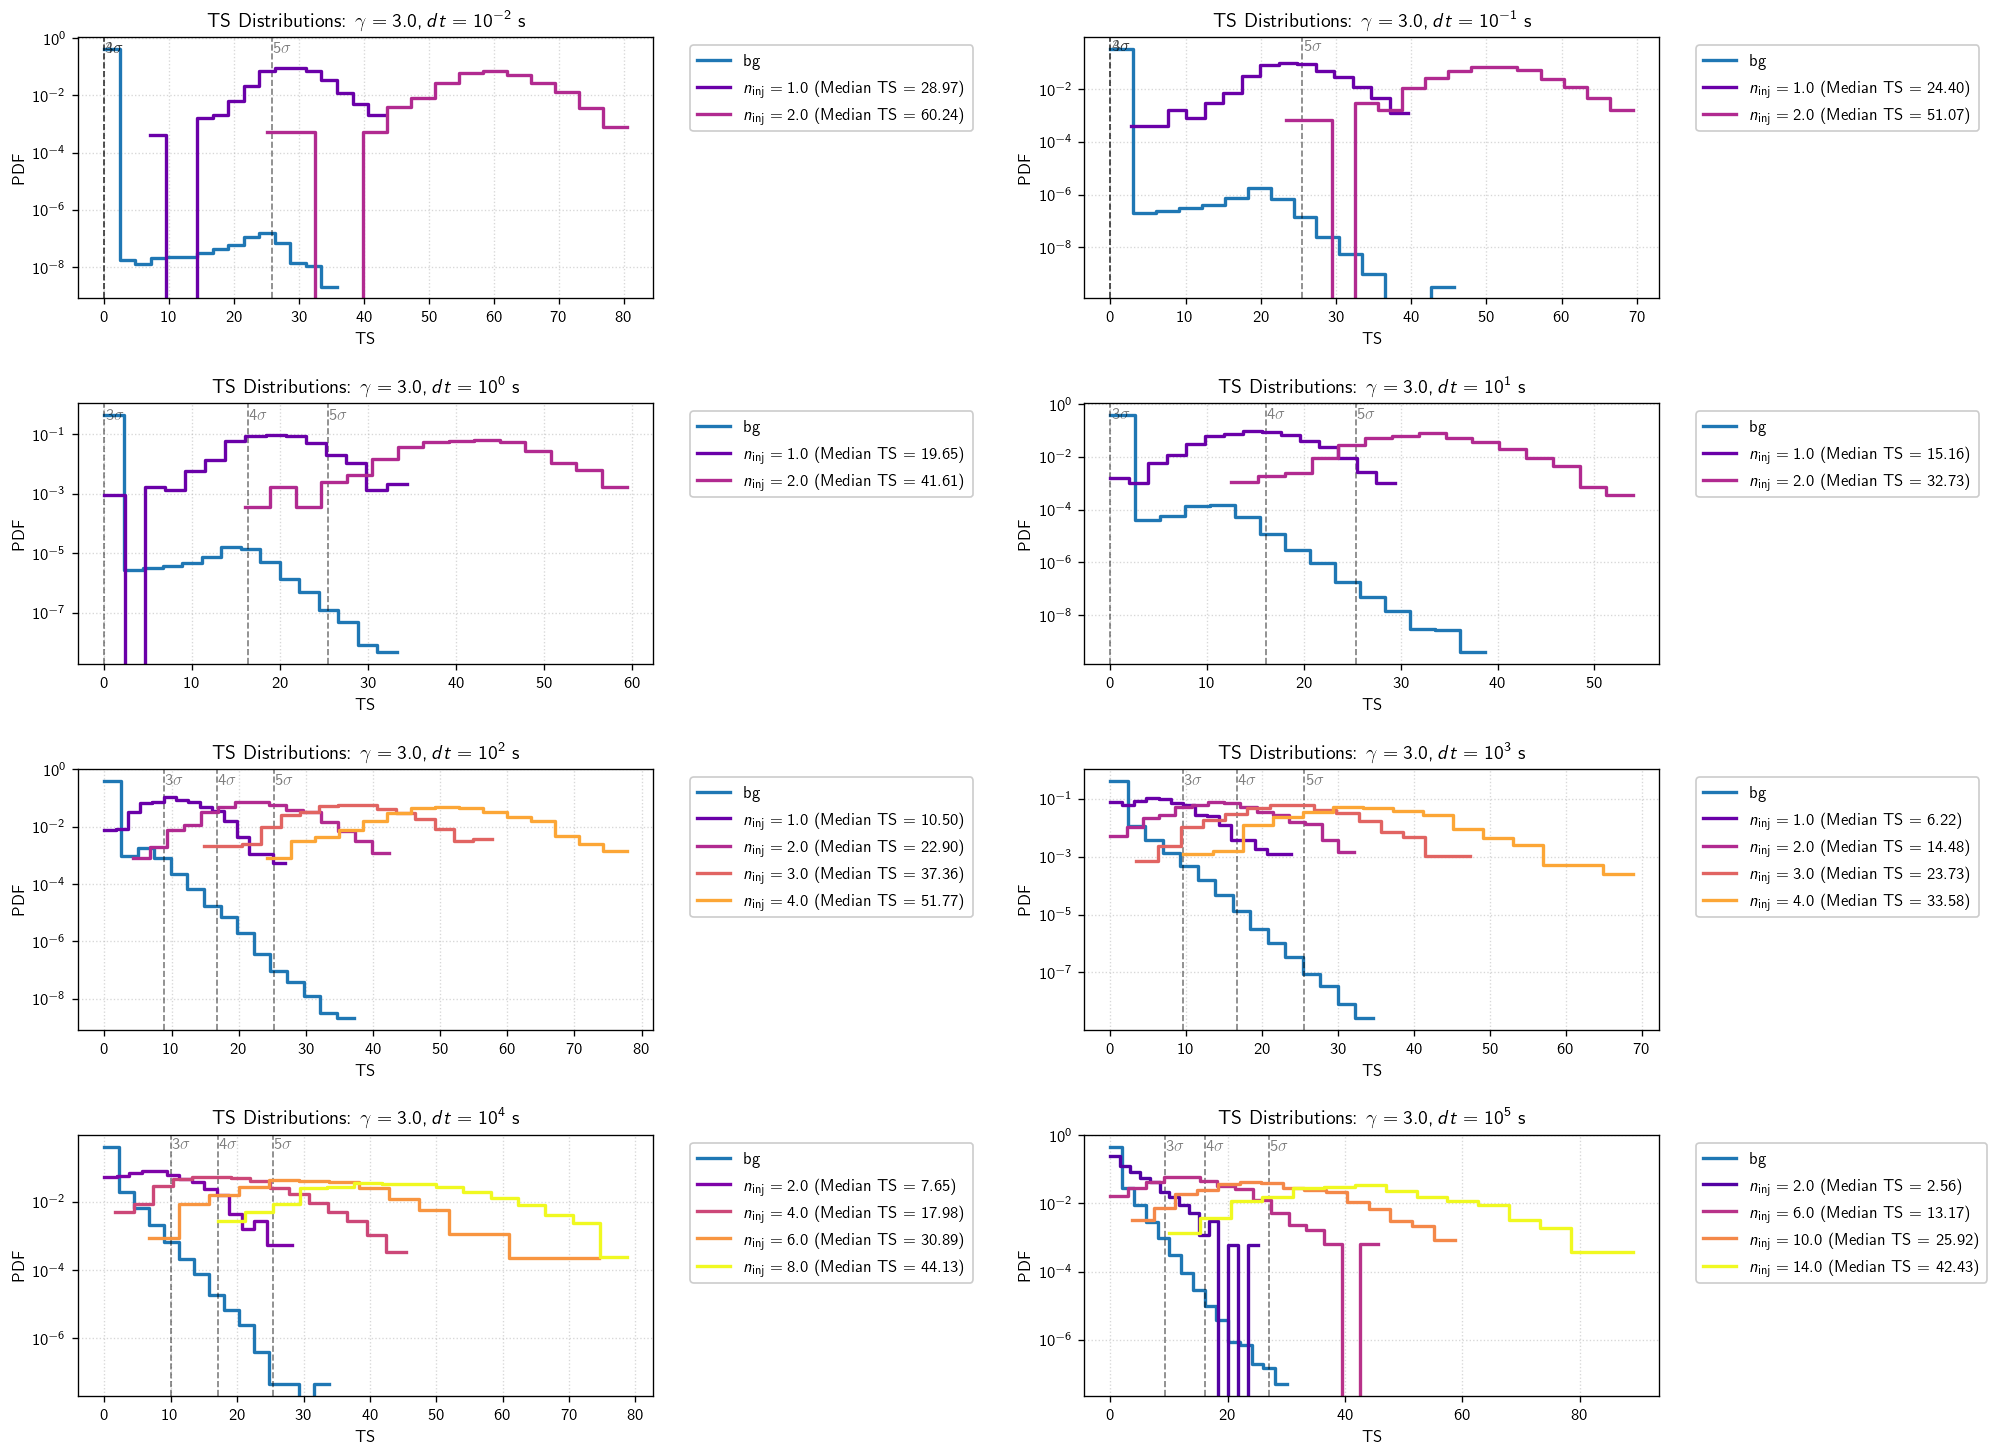

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(17,15))

time_dt = np.logspace(-2, 5, 8) #0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
gamma = 3.0

for (ax, i) in zip(axs.ravel(), time_dt):
    
    dt = i
    bg = bg_trials[i]
    '''
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/{}/'.format(dt),
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    '''
    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10.0

    FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

    FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

    FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

    #using a random seed enables the use of different MC when scrambling
    rand_seed = random.randint(0, 1e5)

    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)

    if dt <= 10.0:
        n_sigs = np.r_[1.0:2.1:1.0]

    elif (dt > 10.0 and dt < 10000.0):
        n_sigs = np.r_[1.0:4.1:1.0]
        
    elif (dt == 10000.0):
        n_sigs = np.r_[2.0:8.1:2.0]
        
    elif (dt == 100000.0):
        n_sigs = np.r_[2.0:14.1:4.0]
        
    print(n_sigs.dtype)
    with time('ps fit bias trials'):
        trials = [tr.get_many_fits(1000, n_sig=n_sig, logging=True, seed=random.randint(0, 1e5), poisson = False) for n_sig in n_sigs]

    sigma = [3,4,5]
    pow = np.log10(dt)
    title = fr'TS Distributions: $\gamma={gamma:.1f}, dt=10^{{{pow:.0f}}}$ s'
    
    #bins=np.r_[:31:2]
    bins = 15
    h = bg.get_hist(bins = bins)
    hl.plot1d(ax, h.normalize(), color='C0',label='bg')
    for i in sigma:
        #color = plt.get_cmap('BuGn')(i/7)
        ax.axvline(bg.isf_nsigma(i),color='k', ls='--', lw = 1.0, alpha = .5) #, label = str(i)+r'$\sigma$', ls=':', lw = 1.0, alpha = .5)
        ax.text(bg.isf_nsigma(i)+.15, .8, r'{}$\sigma$'.format(i), ha='left', va='top', alpha=.5)

    for (n_sig, t) in zip(n_sigs, trials):
        if dt < 10000.0:
            color = plt.get_cmap('plasma')(n_sig/5)
            
        elif dt == 10000.0:
            color = plt.get_cmap('plasma')(n_sig/8)
            
        elif dt > 10000.0:
            color = plt.get_cmap('plasma')(n_sig/14)
            
        hl.plot1d(ax, hl.hist(t.ts, bins=bins).normalize(),
                      color=color, label=fr'$n_\text{{inj}}={n_sig}$ (Median TS = {np.median(t.ts):.2f})')  #.format(n_sig, np.median(t.ts)))
        #ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--',alpha = .6)

    ax.legend(bbox_to_anchor=(1.05, 1), prop={'size': 10})
    ax.set_xlabel('TS')
    ax.set_ylabel('PDF')
    #ax.set(ylim=(1e-7,1))
    #ax.set_title('Background and Signal TS Distributions (gamma = {}, dt = {} s)'.format(gamma, dt))
    ax.set_title(title)
    ax.semilogy()
    ax.grid(alpha = .5)
    
plt.subplots_adjust(wspace = .75, hspace=.4)
fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Bg_Sig_TSD_gamma_{}.png'.format(gamma),bbox_inches='tight')

float64
Performing 10 trials with n_sig = 1.000 using 10 cores:
         10/10 trials complete.   
Performing 10 trials with n_sig = 2.000 using 10 cores:
         10/10 trials complete.   

0:00:04.248096 elapsed.


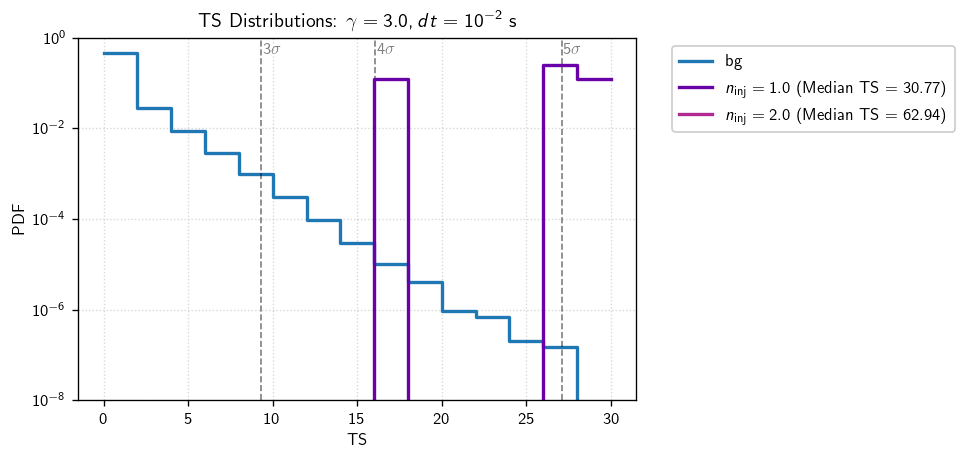

In [100]:
#fig, axs = plt.subplots(4, 2, figsize=(10,12))
fig, ax = plt.subplots()
time_dt = [0.01] #np.logspace(-2, 5, 8) #0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
gamma = 3.0

for i in time_dt:  #(ax, i) in zip(axs.ravel(), time_dt):
    
    dt = i
    '''
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/{}/'.format(dt),
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    '''
    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10.0

    FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

    FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

    FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

    #using a random seed enables the use of different MC when scrambling
    rand_seed = random.randint(0, 1e5)

    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)

    if dt <= 10.0:
        n_sigs = np.r_[1.0:2.1:1.0]

    elif dt > 10.0:
        n_sigs = np.r_[1.0:4.1:1.0]

    print(n_sigs.dtype)
    with time('ps fit bias trials'):
        trials = [tr.get_many_fits(10, n_sig=n_sig, logging=True, seed=random.randint(0, 1e5), poisson = False) for n_sig in n_sigs]

    for t in trials:
        t['mlog10p'] = bg.sf(t.ts)
        t['nsigma'] = bg.sf_nsigma(t.ts)
            #x = bg.trials.ts > t.ts / len(bg)

    sigma = [3,4,5]
    pow = np.log10(dt)
    title = fr'TS Distributions: $\gamma={gamma:.1f}, dt=10^{{{pow:.0f}}}$ s'
    
    bins=np.r_[:31:2]
    h = bg.get_hist(bins = bins)
    hl.plot1d(ax, h.normalize(), color='C0',label='bg')
    for i in sigma:
        #color = plt.get_cmap('BuGn')(i/7)
        ax.axvline(bg.isf_nsigma(i),color='k', ls='--', lw = 1.0, alpha = .5) #, label = str(i)+r'$\sigma$', ls=':', lw = 1.0, alpha = .5)
        ax.text(bg.isf_nsigma(i)+.1, .8, r'{}$\sigma$'.format(i), ha='left', va='top', alpha=.5)

    for (n_sig, t) in zip(n_sigs, trials):
        color = plt.get_cmap('plasma')(n_sig/5)
        hl.plot1d(ax, hl.hist(t.ts, bins=bins).normalize(),
                      color=color, label=fr'$n_\text{{inj}}={n_sig}$ (Median TS = {np.median(t.ts):.2f})')  #.format(n_sig, np.median(t.ts)))
        #ax.axvline(np.median(t.ts), color=color,label=r'$n_\text{{inj}}={}$ median'.format(n_sig), ls='--',alpha = .6)

    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('TS')
    ax.set_ylabel('PDF')
    ax.set(ylim=(1e-8,1))
    ax.set_title(title)
    ax.semilogy()
    ax.grid(alpha = .5)
    
plt.subplots_adjust(wspace = 1.5, hspace=.4)
fig.savefig('/home/mkovacevich/public_html/plots/N_inj/Bg_Sig_TSD_gamma_{}.png'.format(gamma),bbox_inches='tight')